# Effect of as-built dimensions on fatigue life of a monopile foundation

This notebook imports the `owilab_torque2026` package and reproduces the key outputs from the original analysis.

In [25]:
%load_ext autoreload
%autoreload 2
%config InteractiveShell.ast_node_interactivity = 'none'
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# Imports and style
import logging
logging.basicConfig(level=logging.INFO)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

from py_fatigue import SNCurve

from owilab_torque2026 import stress_factors, fatigue, plot


In [27]:
plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams["font.family"] = ["Arial", "monospace"]
plt.rcParams["font.size"] = 10
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.color'] = "#E4E8EE"
plt.rcParams['grid.linestyle'] = "-"
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['lines.markersize'] = 3
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = True


In [28]:
%%html
<style>
@import url('https://fonts.googleapis.com/css2?family=Courier+Prime:wght@400;700&display=swap');
/* Any CSS style can go in here. */
.dataframe th {
    font-size: 12px;
    font-weight: 700;
    font-family: 'Courier Prime', monospace;
}
.dataframe td {
    font-size: 11px;
    font-weight: 400;
    font-family: 'Courier Prime', monospace;
}
</style>


## Nominal parameters and distributions

In [29]:
# Nominal dimensions (mm)
T_nom = 73
t_nom = 68
D_nom = 7200
misalignment_nom = 3

# Tolerances
n_samples = 200000

# t (smaller thickness)
t_tol_low, t_tol_up = 0, 3
L_t, U_t = t_nom + t_tol_low, t_nom + t_tol_up
mean_target_t, sigma_t = t_nom + 0.01 * t_nom, (t_tol_up - t_tol_low) / 6
a_t, b_t = (L_t - mean_target_t) / sigma_t, (U_t - mean_target_t) / sigma_t
trunc_t = truncnorm(a_t, b_t, loc=mean_target_t, scale=sigma_t)
samples_trunc_t = trunc_t.rvs(n_samples)

# T (larger thickness)
T_tol_low, T_tol_up = 0, 3
L_T, U_T = T_nom + T_tol_low, T_nom + T_tol_up
mean_target_T, sigma_T = T_nom + 0.01 * T_nom, (T_tol_up - T_tol_low) / 6
a_T, b_T = (L_T - mean_target_T) / sigma_T, (U_T - mean_target_T) / sigma_T
trunc_T = truncnorm(a_T, b_T, loc=mean_target_T, scale=sigma_T)
samples_trunc_T = trunc_T.rvs(n_samples)

# D (outer diameter)
D_tol_low, D_tol_up = -10, 10
mean_target_D = D_nom
sigma_D = (D_tol_up - D_tol_low) / 6
L_D = D_nom + D_tol_low
U_D = D_nom + D_tol_up
a_D = (L_D - mean_target_D) / sigma_D
b_D = (U_D - mean_target_D) / sigma_D
trunc_D = truncnorm(a_D, b_D, loc=mean_target_D, scale=sigma_D)
samples_trunc_D = trunc_D.rvs(n_samples)

# Misalignment
L_cm, U_cm = 0, 10
mean_misalignment = misalignment_nom
sigma_cm = (U_cm - L_cm) / 6
a_cm, b_cm = (L_cm - mean_misalignment) / sigma_cm, (U_cm - mean_misalignment) / sigma_cm
trunc_misalignment = truncnorm(a_cm, b_cm, loc=mean_misalignment, scale=sigma_cm)
samples_misalignment = trunc_misalignment.rvs(n_samples)

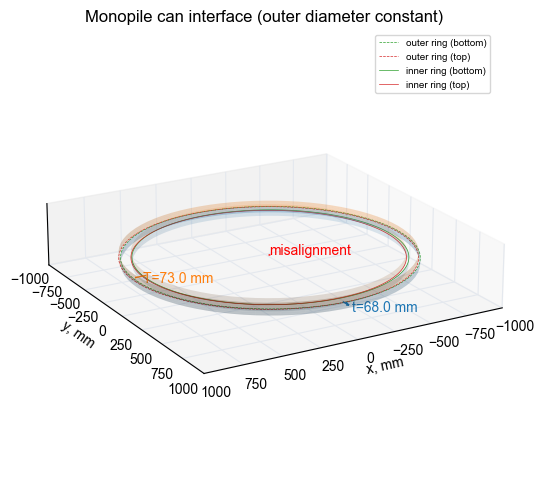

In [30]:
# Show the interface between the cans (magnified x4 for better visibility)
plot.cans_interface_3d(
    t_nom, T_nom, D_nom / 4, misalignment_nom * 4, azim=60, elev=20
)

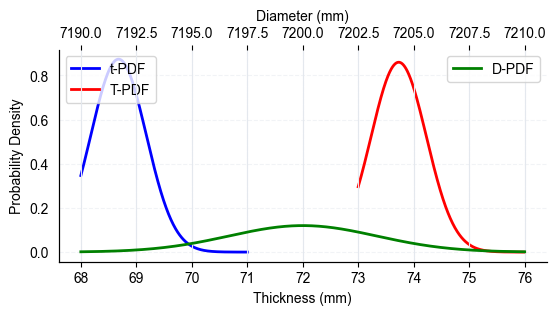

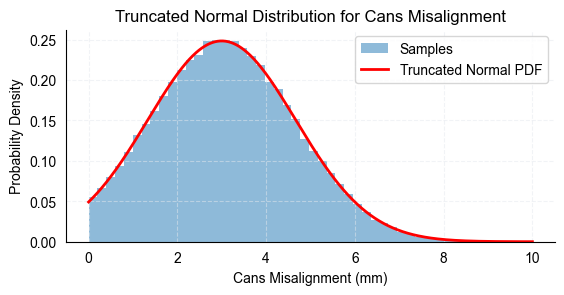

In [31]:
# Plot truncated distributions (using package plotting)
plot.truncated_norms_t1_t2_d(
    trunc_t, trunc_T, trunc_D,
    L_t, U_t, L_T, U_T,
    mean_target_D, D_tol_low, D_tol_up,
)

plot.misalignment_pdf(samples_misalignment, trunc_misalignment, L_cm, U_cm)

## SN curve, design life, and Weibull scale

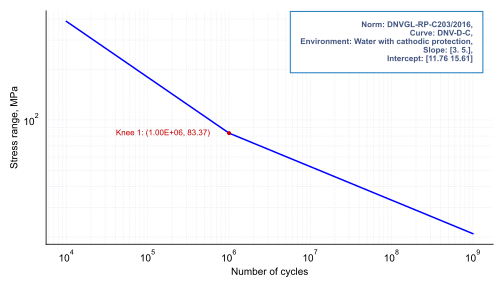

4.291000000003542

In [32]:
# SN curve (Sea water with CP)
sn = SNCurve(
    slope=[3, 5],
    intercept=[11.764, 15.606],
    environment='Water with cathodic protection',
    curve='DNV-D-C',
    norm='DNVGL-RP-C203/2016',
    color='b',
)

display(sn)
m1, m2 = sn.slope
loga1, loga2 = sn.intercept
S = sn.get_knee_stress()[0]

# Design parameters
n = 0.16*3600*24*365
h = 0.8
T = 20
FDF = 3

# Effective thickness parameters
weld_width_nom = 0.64 * t_nom
t_ref = 25
t_eff_allowance = 6
t_corr_exponent = 0.2

# Nominal SMFs (inner reference)
SMF_IN_nom, SMF_OUT_nom = stress_factors.smf_inner_outer(
    D_nom, t_nom, T_nom, misalignment_nom,
    t_ref, t_eff_allowance, t_corr_exponent, weld_width_nom,
    material_factor=1.25, section_modulus_reference="inner",
)

# Solve q_mean for nominal
q_mean = fatigue.solve_weibull_scale_for_damage(
    m1, m2, loga1, loga2, S, h, T, n, FDF, SMF_IN_nom,
)
display(q_mean)

sum(pdf) = 1.0


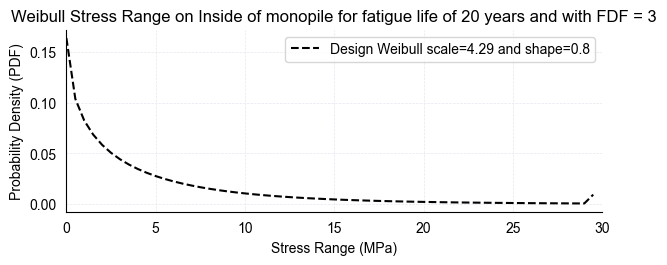

In [33]:
# Weibull PDF plot using q_mean (package plotting)
bin_edges_stress = np.append(np.arange(0, 30, 0.5), np.inf)
k = 0.8
lambda_ = q_mean
x = bin_edges_stress
pdf = fatigue.weibull_bin_pdf(x, k_shape=k, scale=lambda_)
print("sum(pdf) =", pdf.sum())

plot.weibull_pdf(
    x, pdf,
    label=f"Design Weibull scale={lambda_:.2f} and shape={k}",
    title=f"Weibull Stress Range on Inside of monopile for fatigue life of {T} years and with FDF = {FDF}",
    xlim=(0, 30),
)

## Stress multiplication factors and fatigue life grids

In [34]:
# Build DataFrame using nominal settings
df = stress_factors.build_smf_dataframe(
    t_nom, t_tol_up, T_nom, T_tol_up, D_nom, D_tol_low, D_tol_up,
    L_cm, U_cm, t_ref, t_eff_allowance, t_corr_exponent,
    material_factor=1.25, n_t=20, n_t_big=20, n_d=21, n_mis=51
)
display(df.head())
display(df.tail())

,t,T,D,misalignment,I,SCF_in,SCF_out,scale_f,section_mod_out,section_mod_in,SEF_in,SEF_out,SMF_IN,SMF_OUT
0,68.0,73.0,7190.0,0.0,9.647489e+12,0.963638,0.761630,1.133037,2.683585e+09,2.735324e+09,1.002796,1.02213,1.368614,1.102565
1,68.0,73.0,7190.0,0.2,9.647489e+12,0.971719,0.769710,1.133037,2.683585e+09,2.735324e+09,1.002796,1.02213,1.380090,1.114263
2,68.0,73.0,7190.0,0.4,9.647489e+12,0.979799,0.777791,1.133037,2.683585e+09,2.735324e+09,1.002796,1.02213,1.391566,1.125960
3,68.0,73.0,7190.0,0.6,9.647489e+12,0.987879,0.785871,1.133037,2.683585e+09,2.735324e+09,1.002796,1.02213,1.403043,1.137658
4,68.0,73.0,7190.0,0.8,9.647489e+12,0.995960,0.793951,1.133037,2.683585e+09,2.735324e+09,1.002796,1.02213,1.414519,1.149355


,t,T,D,misalignment,I,SCF_in,SCF_out,scale_f,section_mod_out,section_mod_in,SEF_in,SEF_out,SMF_IN,SMF_OUT
428395,71.0,76.0,7210.0,9.2,1.014550e+13,1.316265,1.122237,1.139123,2.814285e+09,2.870825e+09,0.955465,0.974661,1.790764,1.557466
428396,71.0,76.0,7210.0,9.4,1.014550e+13,1.324026,1.129998,1.139123,2.814285e+09,2.870825e+09,0.955465,0.974661,1.801323,1.568237
428397,71.0,76.0,7210.0,9.6,1.014550e+13,1.331787,1.137759,1.139123,2.814285e+09,2.870825e+09,0.955465,0.974661,1.811882,1.579008
428398,71.0,76.0,7210.0,9.8,1.014550e+13,1.339548,1.145521,1.139123,2.814285e+09,2.870825e+09,0.955465,0.974661,1.822441,1.589779
428399,71.0,76.0,7210.0,10.0,1.014550e+13,1.347309,1.153282,1.139123,2.814285e+09,2.870825e+09,0.955465,0.974661,1.833000,1.600550


In [35]:
df = fatigue.compute_fatigue_life(df=df, q_mean=q_mean, sn=sn, h=h, n_cycles=n,
                                  fdf=FDF, s_knee=S)
display(df)

,t,T,D,misalignment,I,SCF_in,SCF_out,scale_f,section_mod_out,section_mod_in,SEF_in,SEF_out,SMF_IN,SMF_OUT,Fatigue_life_IN,Fatigue_life_OUT
0,68.0,73.0,7190.0,0.0,9.647489e+12,0.963638,0.761630,1.133037,2.683585e+09,2.735324e+09,1.002796,1.022130,1.368614,1.102565,35.337614,101.753974
1,68.0,73.0,7190.0,0.2,9.647489e+12,0.971719,0.769710,1.133037,2.683585e+09,2.735324e+09,1.002796,1.022130,1.380090,1.114263,33.916957,96.655740
2,68.0,73.0,7190.0,0.4,9.647489e+12,0.979799,0.777791,1.133037,2.683585e+09,2.735324e+09,1.002796,1.022130,1.391566,1.125960,32.564112,91.859831
3,68.0,73.0,7190.0,0.6,9.647489e+12,0.987879,0.785871,1.133037,2.683585e+09,2.735324e+09,1.002796,1.022130,1.403043,1.137658,31.275340,87.345612
4,68.0,73.0,7190.0,0.8,9.647489e+12,0.995960,0.793951,1.133037,2.683585e+09,2.735324e+09,1.002796,1.022130,1.414519,1.149355,30.047138,83.094035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428395,71.0,76.0,7210.0,9.2,1.014550e+13,1.316265,1.122237,1.139123,2.814285e+09,2.870825e+09,0.955465,0.974661,1.790764,1.557466,9.383297,18.700850
428396,71.0,76.0,7210.0,9.4,1.014550e+13,1.324026,1.129998,1.139123,2.814285e+09,2.870825e+09,0.955465,0.974661,1.801323,1.568237,9.114238,18.075772
428397,71.0,76.0,7210.0,9.6,1.014550e+13,1.331787,1.137759,1.139123,2.814285e+09,2.870825e+09,0.955465,0.974661,1.811882,1.579008,8.854370,17.475547
428398,71.0,76.0,7210.0,9.8,1.014550e+13,1.339548,1.145521,1.139123,2.814285e+09,2.870825e+09,0.955465,0.974661,1.822441,1.589779,8.603329,16.899033


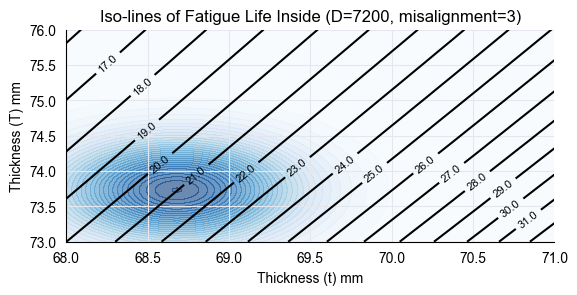

In [36]:
# Slice at fixed D and misalignment for contour of Fatigue_life_IN
D_fix = 7200
mis_fix = 3
tol = 1e-3

df_slice = df[(np.abs(df['D'] - D_fix) < tol) & (np.abs(df['misalignment'] - mis_fix) < tol)]

pivot_t_T = df_slice.pivot_table(index='t', columns='T', values='Fatigue_life_IN')

plot.contour_life_t1_t2(
    pivot_t_T, trunc_t, trunc_T,
    title=f'Iso-lines of Fatigue Life Inside (D={D_fix}, misalignment={mis_fix})'
)

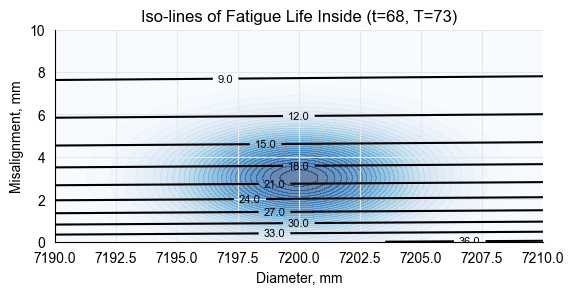

In [37]:
# Slice at fixed t and T for contour of Fatigue_life_IN
t_fix = 68
T_fix = 73
df_slice = df[(np.abs(df['t'] - t_fix) < tol) & (np.abs(df['T'] - T_fix) < tol)]
pivot_D_mis = df_slice.pivot_table(index='D', columns='misalignment',
                                   values='Fatigue_life_IN')
plot.contour_life_d_mis(
        pivot_D_mis, trunc_D, trunc_misalignment,
    title=f'Iso-lines of Fatigue Life Inside (t={t_fix}, T={T_fix})'
)

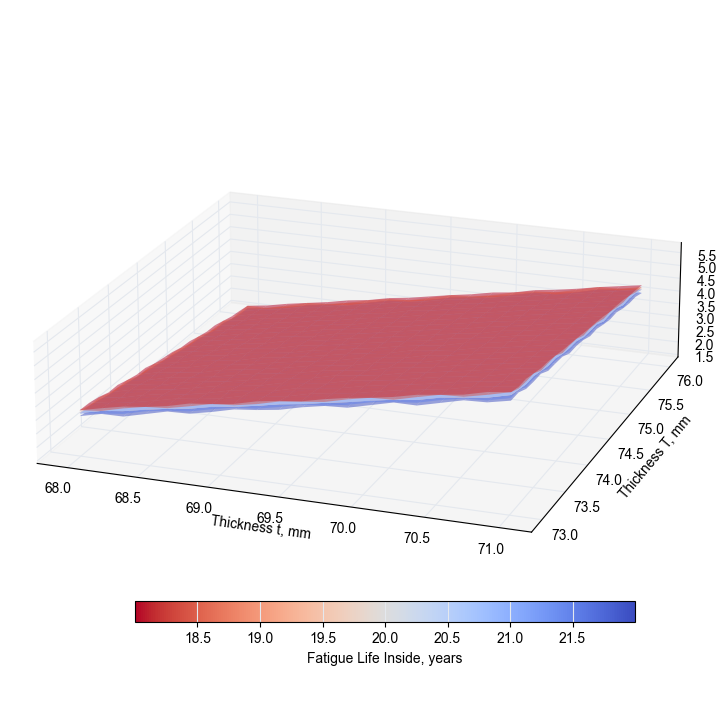

In [38]:
plot.life_surfaces_t1_t2_by_misalignment_at_d(
    df.loc[(df['Fatigue_life_IN'] <= 22) & (df['Fatigue_life_IN'] >= 18)], d_fix=7200
)

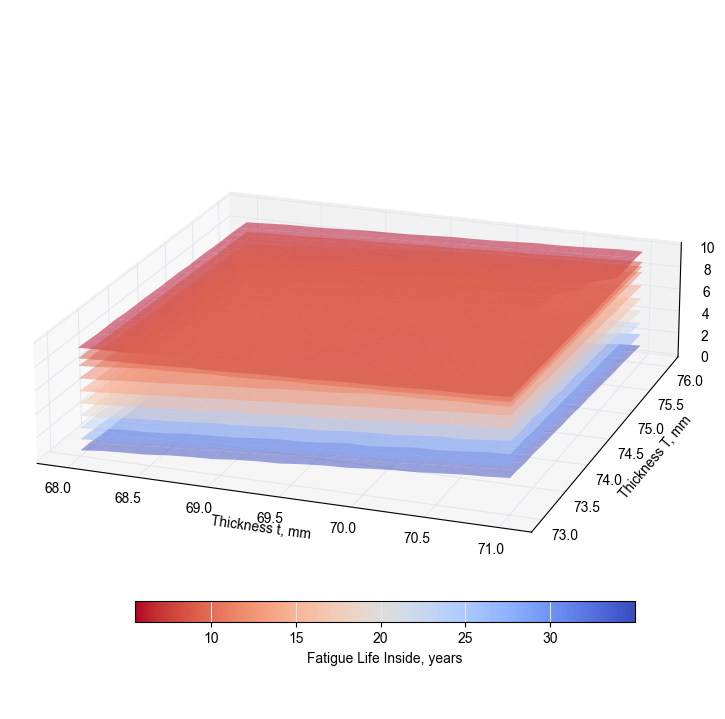

In [39]:
plot.life_surfaces_t1_t2_by_misalignment_at_d(
    df.loc[df['Fatigue_life_IN'] < 35], d_fix=7200
)

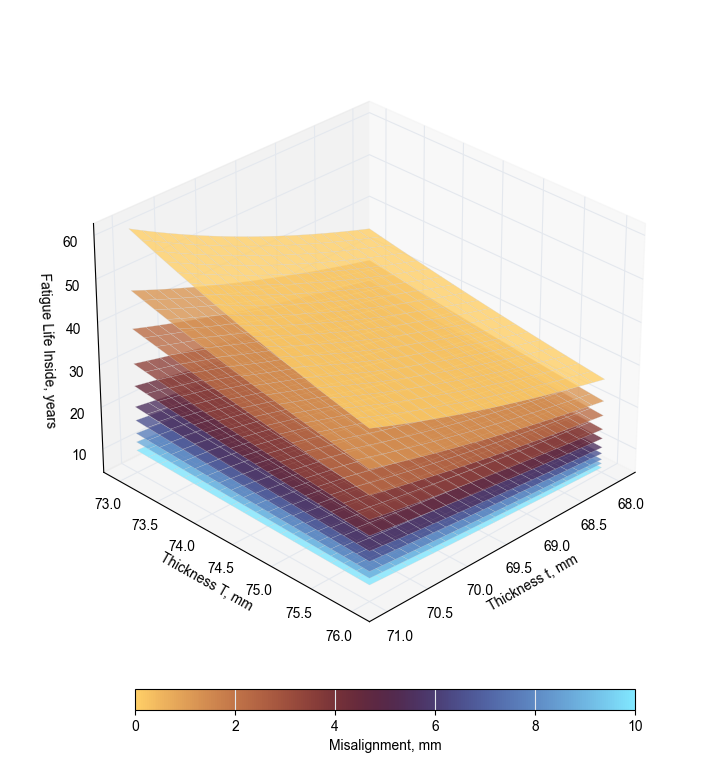

In [ ]:
plot.misalignment_surfaces_t1_t2_by_fatigue_life_at_d(
    df, D_fix,
    trunc_t, trunc_T, trunc_misalignment,
    levels_life=[10, 20, 50, 100, 200],
    elev=30, azim=45,
    cmap='managua',
    alpha=0.8,
    edgecolor='lightgrey',
    linewidth=0.2,
    title=None,
    cmap_position=[0.275, 0, 0.5, 0.03],
    aspect_zoom=0.85
)